### Imports

In [47]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, regularizers
from tensorflow.keras.models import load_model

### Loading the Data

In [2]:
DATA_DIR = "processed_dataset_npy"

def load_signatures(directory):
    signatures = {}
    for user in os.listdir(directory):
        user_path = os.path.join(directory, user)
        if os.path.isdir(user_path):
            files = [f for f in os.listdir(user_path) if f.endswith(".npy")]
            imgs = []
            for file in files:
                img = np.load(os.path.join(user_path, file))
                if img.ndim == 2:
                    img = np.expand_dims(img, axis=-1)
                imgs.append(img)
            signatures[user] = imgs
    return signatures

real_signatures = load_signatures(os.path.join(DATA_DIR, "real"))
fraud_signatures = load_signatures(os.path.join(DATA_DIR, "fraud"))

print("Loaded real signatures for {} users.".format(len(real_signatures)))
print("Loaded fraud signatures for {} users.".format(len(fraud_signatures)))

Loaded real signatures for 37 users.
Loaded fraud signatures for 37 users.


### Generating Siamese Pairs

In [3]:
def generate_siamese_pairs(real_sigs, fraud_sigs, max_pairs_per_user=200):
    pairs = []
    labels = []
    users = list(real_sigs.keys())
    
    for user in users:
        user_real = real_sigs[user]
        if len(user_real) < 2:
            continue 
        
        # Positive pairs: real vs. real (same user)
        pos_pairs = []
        for i in range(len(user_real)):
            for j in range(i+1, len(user_real)):
                pos_pairs.append([user_real[i], user_real[j]])
        if len(pos_pairs) > max_pairs_per_user:
            pos_pairs = random.sample(pos_pairs, max_pairs_per_user)
        for pair in pos_pairs:
            pairs.append(pair)
            labels.append(1)
        
        # Negative pairs: type a (real vs. fraud)
        neg_pairs = []
        if user in fraud_sigs and len(fraud_sigs[user]) > 0:
            for real_img in user_real:
                fraud_img = random.choice(fraud_sigs[user])
                neg_pairs.append([real_img, fraud_img])
        
        # Negative pairs: type b (real vs. real from a different user)
        other_users = [u for u in users if u != user]
        if other_users:
            for real_img in user_real:
                other_user = random.choice(other_users)
                other_img = random.choice(real_sigs[other_user])
                neg_pairs.append([real_img, other_img])
        
        if len(neg_pairs) > max_pairs_per_user:
            neg_pairs = random.sample(neg_pairs, max_pairs_per_user)
        for pair in neg_pairs:
            pairs.append(pair)
            labels.append(0)
    
    return np.array(pairs), np.array(labels)

pairs, pair_labels = generate_siamese_pairs(real_signatures, fraud_signatures, max_pairs_per_user=200)
print("Total pairs generated:", len(pairs))

Total pairs generated: 8892


### Building and Training the Model

In [4]:
def create_signature_cnn(input_shape=(128,128,1)):
    model = tf.keras.Sequential([
        Input(shape=input_shape),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))
    ])
    return model

def build_siamese_model(input_shape=(128,128,1)):
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)
    
    shared_cnn = create_signature_cnn(input_shape)
    embedding_1 = shared_cnn(input_1)
    embedding_2 = shared_cnn(input_2)
    
    # Computing the absolute difference between embeddings.
    def abs_diff(tensors):
        return tf.abs(tensors[0] - tensors[1])

    def output_shape(input_shapes):
        return (input_shapes[0][0], input_shapes[0][1])

    diff = layers.Lambda(abs_diff, output_shape=output_shape)([embedding_1, embedding_2])
    
    output = layers.Dense(1, activation='sigmoid')(diff)
    
    model = Model(inputs=[input_1, input_2], outputs=output)
    return model


siamese_model = build_siamese_model()
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
siamese_model.summary()

pairs_train, pairs_val, labels_train, labels_val = train_test_split(
    pairs, pair_labels, test_size=0.2, random_state=42
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = siamese_model.fit(
    [pairs_train[:,0], pairs_train[:,1]],
    labels_train,
    batch_size=32,
    epochs=15,
    validation_data=([pairs_val[:,0], pairs_val[:,1]], labels_val),
    callbacks=[early_stopping]
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128)       │ 33,662,080 │ input_layer[0][0… │
│ (Sequential)        │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,662,209 (128.41 MB)

 Trainable params: 33,662,209 (128.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - accuracy: 0.7788 - loss: 0.9141 - val_accuracy: 0.8364 - val_loss: 0.7127
Epoch 2/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 32s 144ms/step - accuracy: 0.8550 - loss: 0.6726 - val_accuracy: 0.8713 - val_loss: 0.6694
Epoch 3/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 32s 143ms/step - accuracy: 0.8932 - loss: 0.5798 - val_accuracy: 0.8938 - val_loss: 0.6234
Epoch 4/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 32s 144ms/step - accuracy: 0.9054 - loss: 0.5633 - val_accuracy: 0.9011 - val_loss: 0.5505
Epoch 5/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 32s 144ms/step - accuracy: 0.9297 - loss: 0.4722 - val_accuracy: 0.8977 - val_loss: 0.5258
Epoch 6/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 33s 146ms/step - accuracy: 0.9398 - loss: 0.4211 - val_accuracy: 0.9269 - val_loss: 0.4442
Epoch 7/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 32s 144ms/step - accuracy: 0.9534 - loss: 0.3464 - val_accuracy: 0.9174 - val_loss: 0.4565
Epoch 8/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 32s 144ms/step - accuracy: 0.9553 - loss: 0

In [45]:
print(f"Training Pair {len(pairs_train)}\nTesting Pair {len(pairs_val)}")

Training Pair 7113
Testing Pair 1779


### Saving the Model

In [5]:
siamese_model.save("Siamese.keras")

### Visualize Training and Validation Metrices

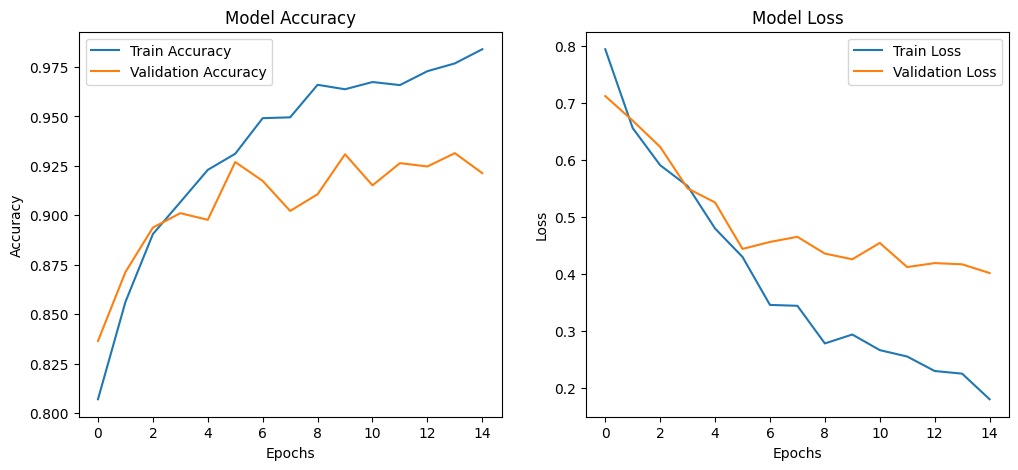

In [6]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Loss
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.show()

plot_training_history(history)

### Evaluation of 15 Samples

In [55]:
def evaluate_on_random_samples(model, val_pairs, val_labels, num_samples=15):
    random_indices = random.sample(range(len(val_pairs)), num_samples)
    selected_pairs = val_pairs[random_indices]
    selected_labels = val_labels[random_indices]
    selected_input_1 = selected_pairs[:, 0]
    selected_input_2 = selected_pairs[:, 1]
    
    predictions = model.predict([selected_input_1, selected_input_2])
    
    print("Evaluation on {} random validation samples:".format(num_samples))
    for i, (pred, true_label) in enumerate(zip(predictions, selected_labels)):
        pred_label = int(pred[0] > 0.95)
        print(f"Sample {i+1}:")
        print(f"  Predicted Score: {pred[0]:.4f}")
        print(f"  Predicted Label: {'Genuine' if pred_label == 1 else 'Forgery'}")
        print(f"  True Label: {'Genuine' if true_label == 1 else 'Forgery'}")
        print("-" * 30)

evaluate_on_random_samples(siamese_model, pairs_val, labels_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Evaluation on 15 random validation samples:
Sample 1:
  Predicted Score: 0.9761
  Predicted Label: Genuine
  True Label: Genuine
------------------------------
Sample 2:
  Predicted Score: 0.3505
  Predicted Label: Forgery
  True Label: Genuine
------------------------------
Sample 3:
  Predicted Score: 0.9999
  Predicted Label: Genuine
  True Label: Genuine
------------------------------
Sample 4:
  Predicted Score: 0.0028
  Predicted Label: Forgery
  True Label: Forgery
------------------------------
Sample 5:
  Predicted Score: 0.0000
  Predicted Label: Forgery
  True Label: Forgery
------------------------------
Sample 6:
  Predicted Score: 0.9010
  Predicted Label: Forgery
  True Label: Genuine
------------------------------
Sample 7:
  Predicted Score: 0.9992
  Predicted Label: Genuine
  True Label: Genuine
------------------------------
Sample 8:
  Predicted Score: 0.3057
  Predicted Label: Forgery
  True Label: Forgery
---------------------

### View Confusion Matrix

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


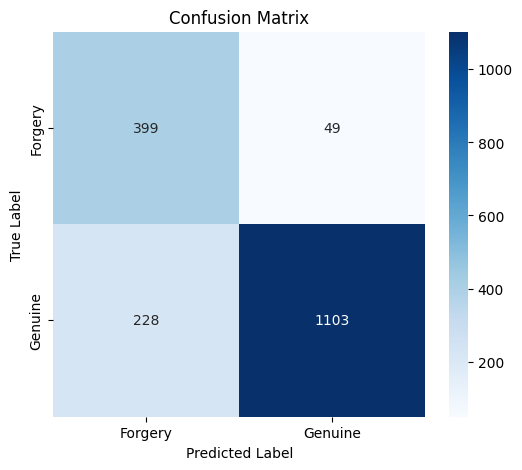

Classification Report:
              precision    recall  f1-score   support

     Forgery       0.64      0.89      0.74       448
     Genuine       0.96      0.83      0.89      1331

    accuracy                           0.84      1779
   macro avg       0.80      0.86      0.82      1779
weighted avg       0.88      0.84      0.85      1779



In [56]:
def plot_confusion_matrix(model, val_pairs, val_labels):
    predictions = model.predict([val_pairs[:,0], val_pairs[:,1]])
    pred_labels = (predictions > 0.95).astype(int).flatten()
    cm = confusion_matrix(val_labels, pred_labels)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Forgery', 'Genuine'],
                yticklabels=['Forgery', 'Genuine'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    report = classification_report(val_labels, pred_labels, target_names=['Forgery', 'Genuine'])
    print("Classification Report:")
    print(report)

plot_confusion_matrix(siamese_model, pairs_val, labels_val)

### View False Positives 

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


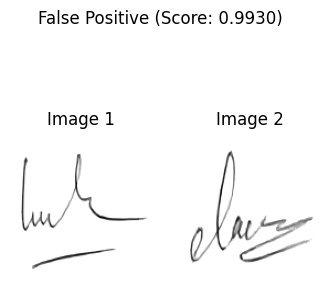

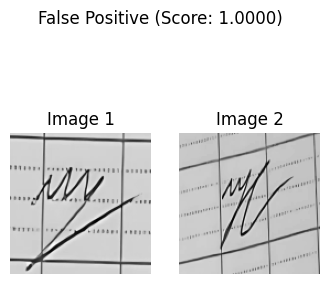

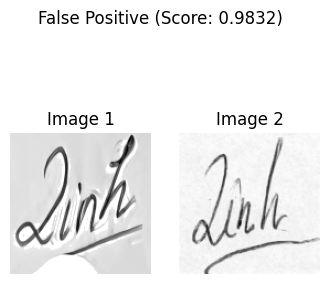

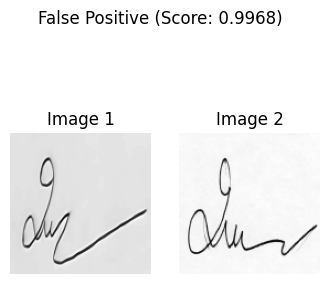

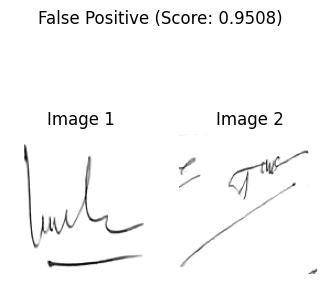

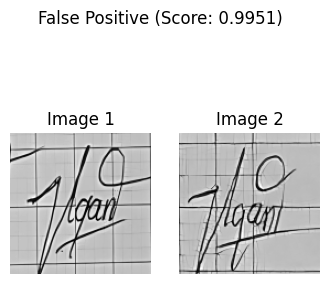

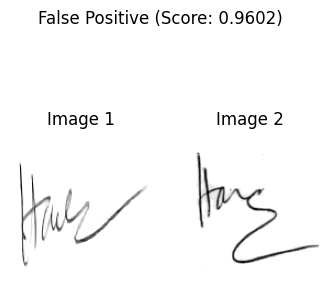

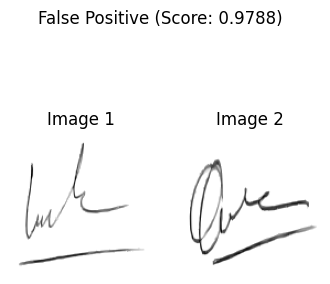

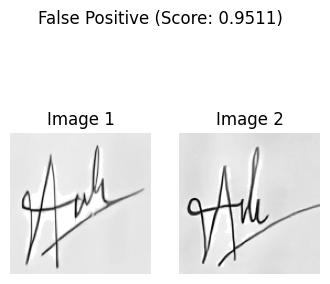

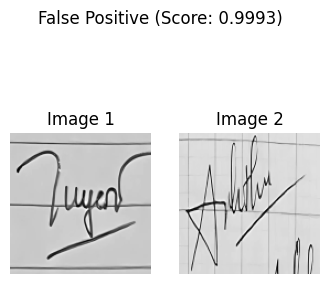

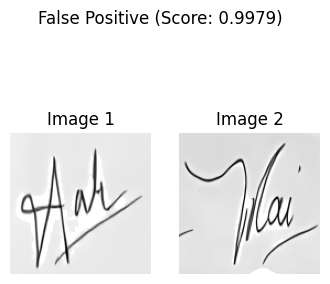

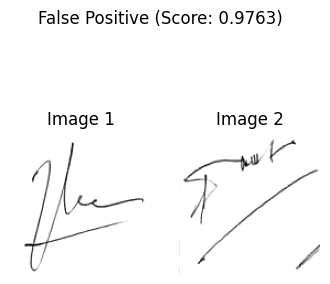

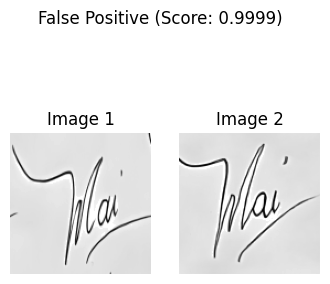

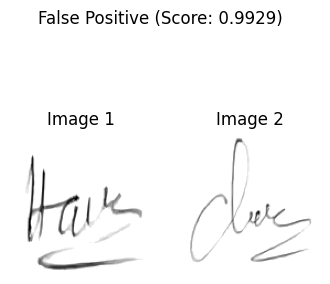

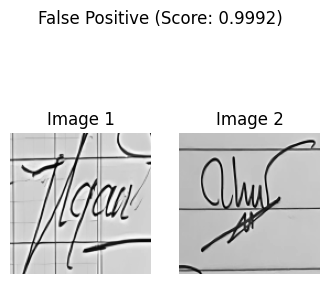

In [57]:
def display_false_positive_samples(model, val_pairs, val_labels, num_samples=5, threshold=0.95):
    """
    Displays a specified number of validation sample pairs that were misclassified as genuine (false positives).
    """
    predictions = model.predict([val_pairs[:,0], val_pairs[:,1]])
    false_positive_indices = [
        i for i, (pred, true) in enumerate(zip(predictions, val_labels))
        if pred[0] > threshold and true == 0
    ]
    
    if len(false_positive_indices) == 0:
        print("No false positive samples found.")
        return
    
    selected_indices = random.sample(false_positive_indices, min(num_samples, len(false_positive_indices)))
    
    for idx in selected_indices:
        img1 = val_pairs[idx, 0]
        img2 = val_pairs[idx, 1]
        pred_score = predictions[idx][0]
        
        plt.figure(figsize=(4,4))
        plt.subplot(1,2,1)
        plt.imshow(img1.squeeze(), cmap='gray')
        plt.title("Image 1")
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(img2.squeeze(), cmap='gray')
        plt.title("Image 2")
        plt.axis('off')
        plt.suptitle(f"False Positive (Score: {pred_score:.4f})")

# Displaying x false positive samples
display_false_positive_samples(siamese_model, pairs_val, labels_val, num_samples=15)
plt.show()


### Manual Verification

Enter the user id:  a37
Enter the path to the signature image:  Dataset/real/a37/a37_crop_32.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


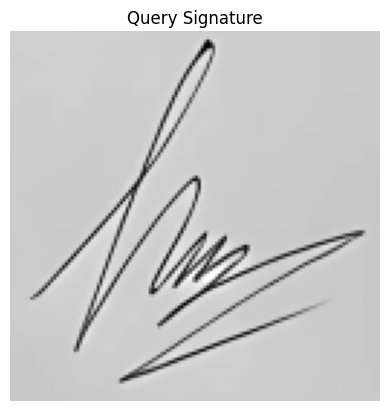

In [28]:
IMG_SIZE = (128, 128)

def preprocess_image(image_path):
    """
    Preprocesses an image by cleaning noise, resizing, and normalizing.
    Returns the processed image as a float32 array in [0, 1].
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image {image_path}")
    
    # Converting to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resizing image to target size
    resized = cv2.resize(gray, IMG_SIZE, interpolation=cv2.INTER_AREA)
    
    # Creating a binary mask for rich strokes
    _, binary_mask = cv2.threshold(resized, 240, 255, cv2.THRESH_BINARY)
    
    # A white canvas
    blank_canvas = np.ones_like(resized, dtype=np.uint8) * 255
    
    # Transferring only rich strokes to the blank canvas
    blank_canvas[binary_mask == 0] = resized[binary_mask == 0]
    
    # Normalize the resulting canvas to range [0, 1]
    normalized = blank_canvas.astype("float32") / 255.0
    
    return normalized

def load_genuine_signatures(user_id, real_dir="processed_dataset_npy/real"):
    """
    Loads all preprocessed .npy signature images for the given user.
    Each image is expected to be stored as a 2D array (128,128), so we expand dims.
    """
    user_dir = os.path.join(real_dir, user_id)
    if not os.path.isdir(user_dir):
        raise ValueError(f"No genuine data found for user '{user_id}' in {user_dir}")
    
    imgs = []
    for file in os.listdir(user_dir):
        if file.endswith(".npy"):
            img = np.load(os.path.join(user_dir, file))
            if img.ndim == 2:
                img = np.expand_dims(img, axis=-1)
            imgs.append(img)
    if not imgs:
        raise ValueError(f"No genuine .npy files found for user '{user_id}'.")
    return imgs

# Load the trained Siamese model with custom_objects

def abs_diff(tensors):
    return tf.abs(tensors[0] - tensors[1])

def output_shape(input_shapes):
    return input_shapes[0]

def load_siamese_model(model_path):
    custom_objs = {'abs_diff': abs_diff, 'output_shape': output_shape}
    model = load_model(model_path, custom_objects=custom_objs)
    return model
    
def verify_user_signature(user_id, query_image_path, threshold=0.95):
    """
    Verifies whether the provided signature image belongs to the claimed user.
    It compares the query signature (processed using the preprocessor) with all
    genuine signatures for that user using your Siamese model.
    Parameters:
      user_id: str - the claimed user id.
      query_image_path: str - path to the signature image to be verified.
      threshold: float - average similarity score above which the signature is verified.
    """
    siamese_model = load_siamese_model("Siamese.keras")
    
    # Process the query image
    query_img = preprocess_image(query_image_path)
    # Ensure shape (128,128,1)
    query_img = np.expand_dims(query_img, axis=-1)
    
    genuine_imgs = load_genuine_signatures(user_id)
    
    scores = []
    for genuine in genuine_imgs:
        query_batch = np.expand_dims(query_img, axis=0)
        genuine_batch = np.expand_dims(genuine, axis=0)
        score = siamese_model.predict([query_batch, genuine_batch])[0][0]
        scores.append(score)
    
    avg_score = np.mean(scores)
    print(f"Average similarity score for user '{user_id}': {avg_score:.4f}")
    if avg_score >= threshold:
        print("=> Signature VERIFIED for this user.")
    else:
        print("=> Signature NOT VERIFIED for this user.")
    
    plt.imshow(query_img.squeeze(), cmap='gray')
    plt.title("Query Signature")
    plt.axis('off')
    plt.show()

user_id_input = input("Enter the user id: ").strip()
query_signature_path = input("Enter the path to the signature image: ").strip()
verify_user_signature(user_id_input, query_signature_path, threshold=0.95)
